import
rename columns
underweight, normal, overweight -> normal (0)
Obesity -> obesity (1)
Encode Gender, Mtrans
Family_history, FAVC, Smoke to 0 and 1
Caec, Calc 0,1,2,3
Basic visualizaiton, histogram, 
describe
train model (XGBOOST)
performance stats, accuracy, Confusion Matrix
    (Repeat with Random Forest)
Hyperparameter Tuning. 
GUI

In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
import os
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import tkinter as tk
from tkinter import messagebox



Downloads zip, extracts csv from zip and loads data into pandas df. 

In [2]:
f_zip = 'http://archive.ics.uci.edu/static/public/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip'
r = requests.get(f_zip)
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    
    csv_filename = 'ObesityDataSet_raw_and_data_sinthetic.csv'
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)


In [3]:
null_counts = df.isnull().sum()
print("Null Values:")
print(null_counts)

Null Values:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [4]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
df.shape

(2111, 17)

In [6]:
df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

Renaming the columns for ease of understanding

In [7]:
df = df.rename(columns={
    'family_history_with_overweight': 'family_history',
    'FAVC': 'high_caloric_food',
    'FCVC': 'vegetable_intake',
    'NCP': 'num_meals',
    'CAEC': 'snacks_btw_meals',
    'CH2O': 'water_intake',
    'SCC': 'monitor_calories?',
    'FAF': 'physical_activity',
    'TUE': 'tech_time',
    'CALC': 'alcohol',
    'MTRANS': 'transportation_mode',
    'NObeyesdad': 'obesity_level'
})

print(df.head())


   Gender   Age  Height  Weight family_history high_caloric_food  \
0  Female  21.0    1.62    64.0            yes                no   
1  Female  21.0    1.52    56.0            yes                no   
2    Male  23.0    1.80    77.0            yes                no   
3    Male  27.0    1.80    87.0             no                no   
4    Male  22.0    1.78    89.8             no                no   

   vegetable_intake  num_meals snacks_btw_meals SMOKE  water_intake  \
0               2.0        3.0        Sometimes    no           2.0   
1               3.0        3.0        Sometimes   yes           3.0   
2               2.0        3.0        Sometimes    no           2.0   
3               3.0        3.0        Sometimes    no           2.0   
4               2.0        1.0        Sometimes    no           2.0   

  monitor_calories?  physical_activity  tech_time     alcohol  \
0                no                0.0        1.0          no   
1               yes               

In [8]:
df.describe()

,Age,Height,Weight,vegetable_intake,num_meals,water_intake,physical_activity,tech_time
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [9]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [10]:
df.head()

,obesity_level,Gender,Age,Height,Weight,family_history,high_caloric_food,vegetable_intake,num_meals,snacks_btw_meals,SMOKE,water_intake,monitor_calories?,physical_activity,tech_time,alcohol,transportation_mode
0,Normal_Weight,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Normal_Weight,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Normal_Weight,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Overweight_Level_I,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Overweight_Level_II,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


One Hot Encoding:

In [11]:

df['Is_Male'] = (df['Gender'] == 'Male').astype(int)
df['Is_Female'] = (df['Gender'] == 'Female').astype(int)

df.drop(columns=['Gender'], inplace=True)

df.head()


,obesity_level,Age,Height,Weight,family_history,high_caloric_food,vegetable_intake,num_meals,snacks_btw_meals,SMOKE,water_intake,monitor_calories?,physical_activity,tech_time,alcohol,transportation_mode,Is_Male,Is_Female
0,Normal_Weight,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,0,1
1,Normal_Weight,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,0,1
2,Normal_Weight,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1,0
3,Overweight_Level_I,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,1,0
4,Overweight_Level_II,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,1,0


In [12]:

df_transportation_mode = pd.get_dummies(df['transportation_mode'], prefix='transport_mode')

df_transportation_mode = df_transportation_mode.astype(int)

df = pd.concat([df, df_transportation_mode], axis=1)

df.drop(columns=['transportation_mode'], inplace=True)

df.head()

,obesity_level,Age,Height,Weight,family_history,high_caloric_food,vegetable_intake,num_meals,snacks_btw_meals,SMOKE,...,physical_activity,tech_time,alcohol,Is_Male,Is_Female,transport_mode_Automobile,transport_mode_Bike,transport_mode_Motorbike,transport_mode_Public_Transportation,transport_mode_Walking
0,Normal_Weight,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,...,0.0,1.0,no,0,1,0,0,0,1,0
1,Normal_Weight,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,...,3.0,0.0,Sometimes,0,1,0,0,0,1,0
2,Normal_Weight,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,...,2.0,1.0,Frequently,1,0,0,0,0,1,0
3,Overweight_Level_I,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,...,2.0,0.0,Frequently,1,0,0,0,0,0,1
4,Overweight_Level_II,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,...,0.0,0.0,Sometimes,1,0,0,0,0,1,0


Binary Encoding

In [13]:
df['family_history'] = df['family_history'].map({'yes': 1, 'no': 0})
df['high_caloric_food'] = df['high_caloric_food'].map({'yes': 1, 'no': 0})
df['SMOKE'] = df['SMOKE'].map({'yes': 1, 'no': 0})
df['monitor_calories?'] = df['monitor_calories?'].map({'yes': 1, 'no': 0})
print(df.head())

         obesity_level   Age  Height  Weight  family_history  \
0        Normal_Weight  21.0    1.62    64.0               1   
1        Normal_Weight  21.0    1.52    56.0               1   
2        Normal_Weight  23.0    1.80    77.0               1   
3   Overweight_Level_I  27.0    1.80    87.0               0   
4  Overweight_Level_II  22.0    1.78    89.8               0   

   high_caloric_food  vegetable_intake  num_meals snacks_btw_meals  SMOKE  \
0                  0               2.0        3.0        Sometimes      0   
1                  0               3.0        3.0        Sometimes      1   
2                  0               2.0        3.0        Sometimes      0   
3                  0               3.0        3.0        Sometimes      0   
4                  0               2.0        1.0        Sometimes      0   

   ...  physical_activity  tech_time     alcohol  Is_Male Is_Female  \
0  ...                0.0        1.0          no        0         1   
1  ...    

Label Encoding: Categorical Values  --> Numerical

In [14]:

caec_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}

df['snacks_btw_meals'] = df['snacks_btw_meals'].map(caec_mapping)
df['alcohol'] = df['alcohol'].map(caec_mapping)

df.head()


,obesity_level,Age,Height,Weight,family_history,high_caloric_food,vegetable_intake,num_meals,snacks_btw_meals,SMOKE,...,physical_activity,tech_time,alcohol,Is_Male,Is_Female,transport_mode_Automobile,transport_mode_Bike,transport_mode_Motorbike,transport_mode_Public_Transportation,transport_mode_Walking
0,Normal_Weight,21.0,1.62,64.0,1,0,2.0,3.0,1,0,...,0.0,1.0,0,0,1,0,0,0,1,0
1,Normal_Weight,21.0,1.52,56.0,1,0,3.0,3.0,1,1,...,3.0,0.0,1,0,1,0,0,0,1,0
2,Normal_Weight,23.0,1.80,77.0,1,0,2.0,3.0,1,0,...,2.0,1.0,2,1,0,0,0,0,1,0
3,Overweight_Level_I,27.0,1.80,87.0,0,0,3.0,3.0,1,0,...,2.0,0.0,2,1,0,0,0,0,0,1
4,Overweight_Level_II,22.0,1.78,89.8,0,0,2.0,1.0,1,0,...,0.0,0.0,1,1,0,0,0,0,1,0


In [15]:
df['obesity_level'].value_counts()

obesity_level
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Label mapping each class to binary value. maps value into df. 

In [16]:
label_map = {
    'Obesity_Type_I': 1,
    'Obesity_Type_II': 1,
    'Obesity_Type_III': 1,
    'Overweight_Level_I': 0,
    'Overweight_Level_II': 0,
    'Normal_Weight': 0,
    'Insufficient_Weight': 0
}

df['obesity_level'] = df['obesity_level'].map(label_map)

print(df['obesity_level'].value_counts())

obesity_level
0    1139
1     972
Name: count, dtype: int64


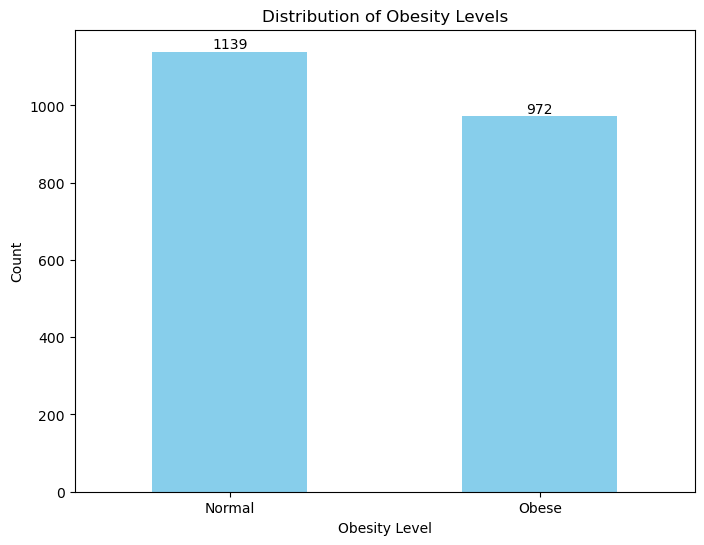

In [17]:
obesity_counts = df['obesity_level'].value_counts()

plt.figure(figsize=(8, 6))
obesity_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Obesity Levels')
plt.xlabel('Obesity Level')
plt.ylabel('Count')

plt.xticks([0, 1], ['Normal', 'Obese'],rotation=0)
for i, count in enumerate(obesity_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   obesity_level                         2111 non-null   int64  
 1   Age                                   2111 non-null   float64
 2   Height                                2111 non-null   float64
 3   Weight                                2111 non-null   float64
 4   family_history                        2111 non-null   int64  
 5   high_caloric_food                     2111 non-null   int64  
 6   vegetable_intake                      2111 non-null   float64
 7   num_meals                             2111 non-null   float64
 8   snacks_btw_meals                      2111 non-null   int64  
 9   SMOKE                                 2111 non-null   int64  
 10  water_intake                          2111 non-null   float64
 11  monitor_calories?

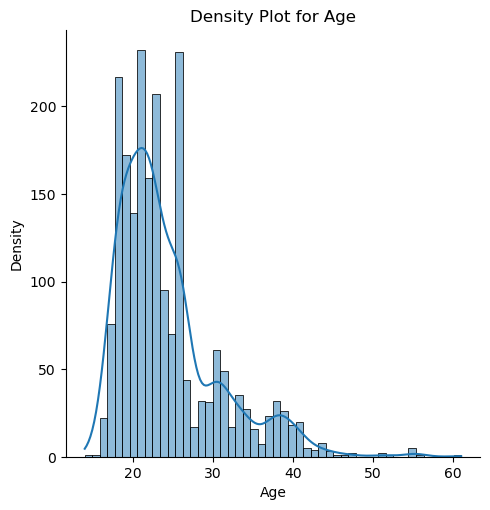

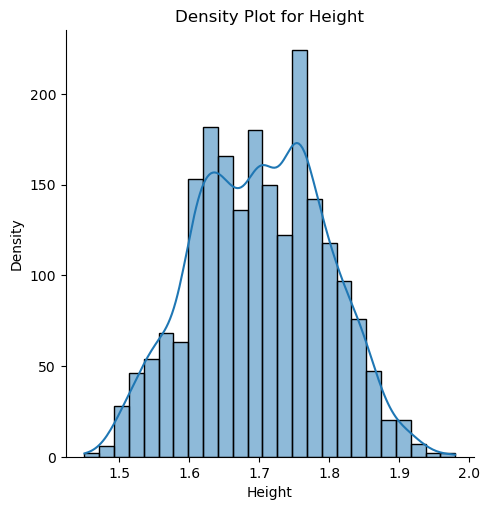

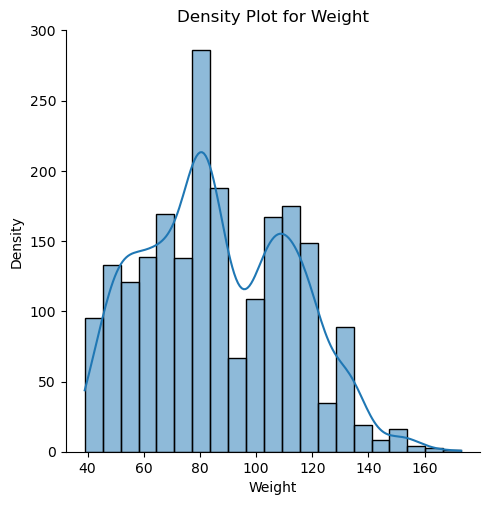

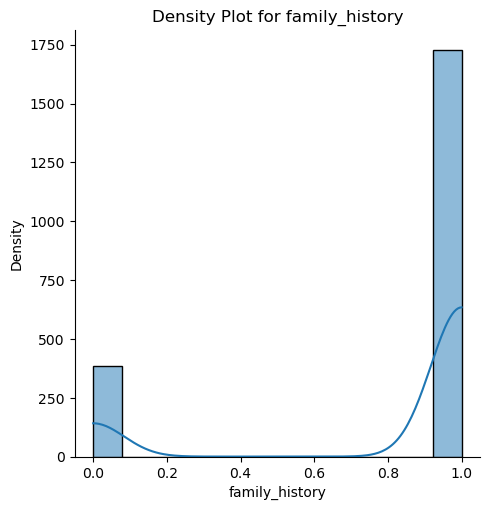

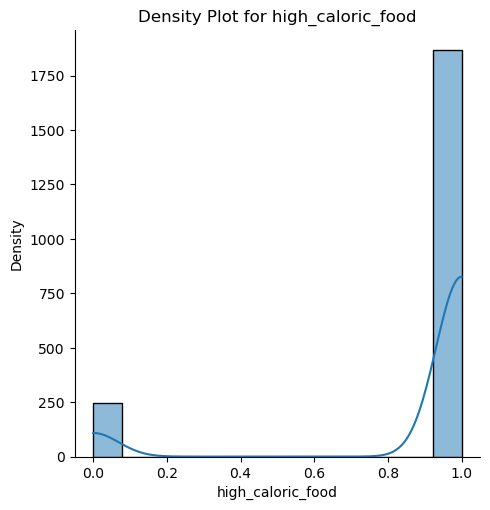

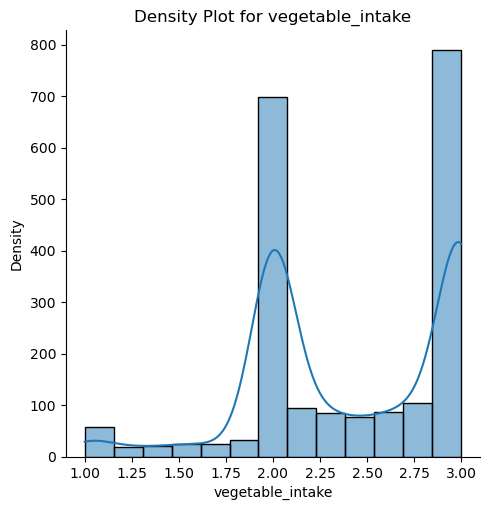

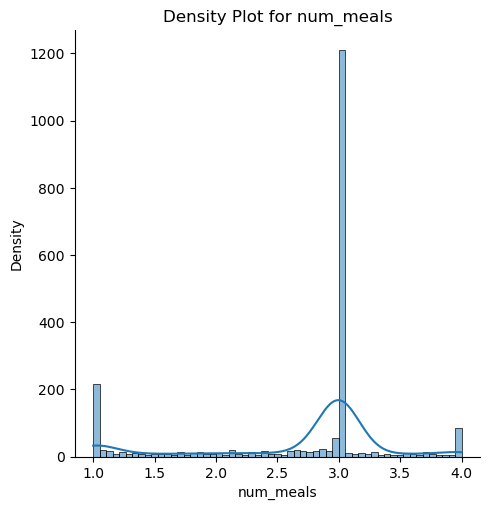

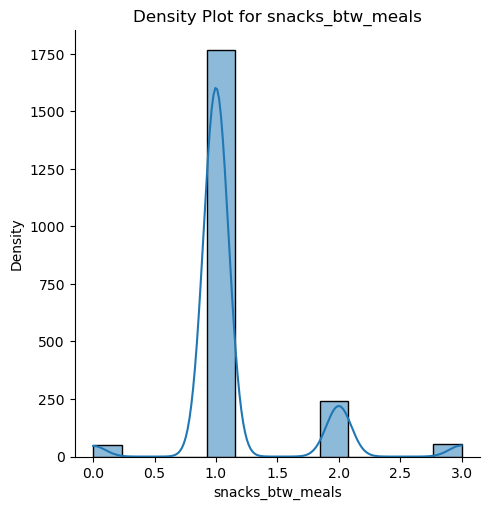

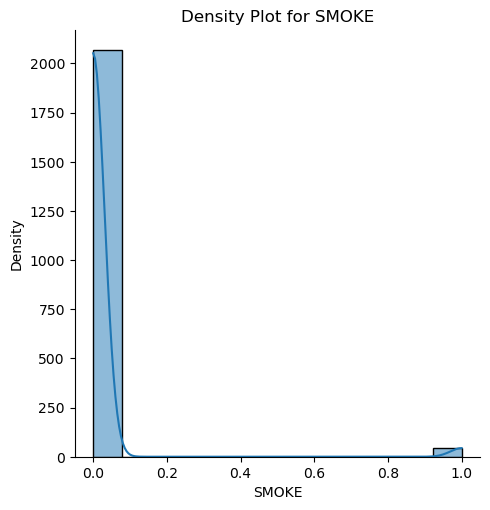

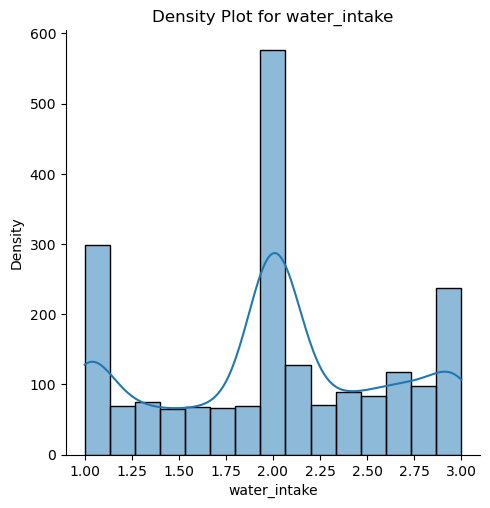

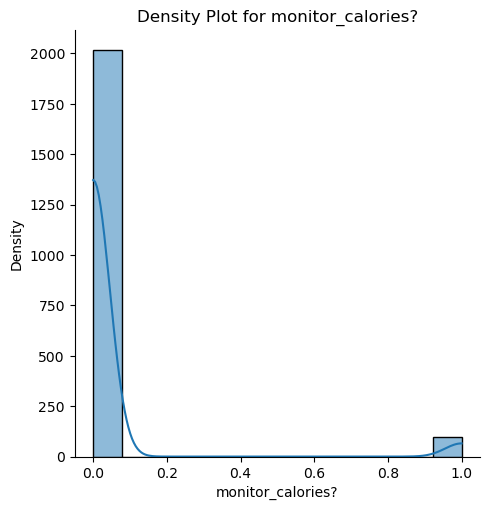

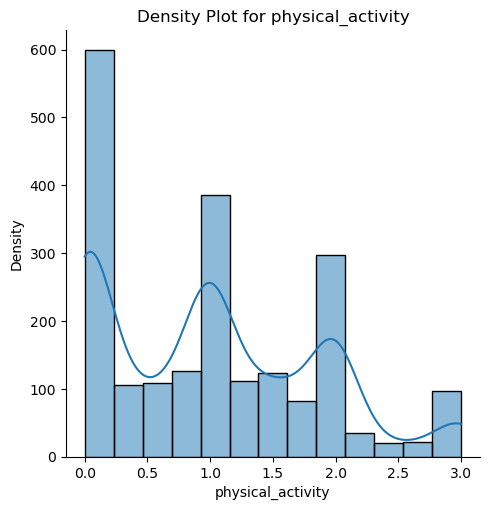

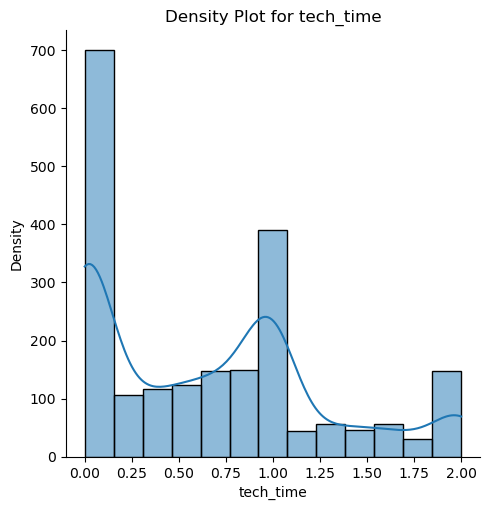

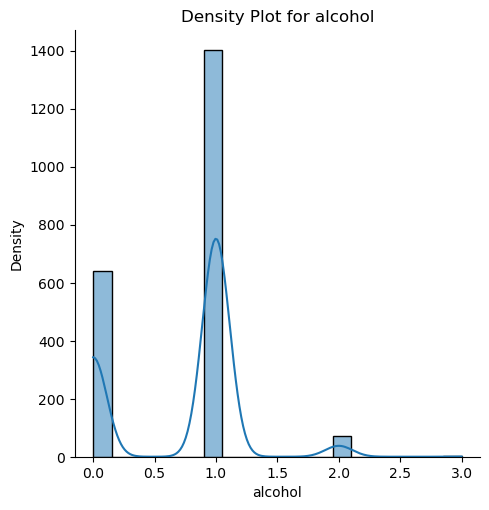

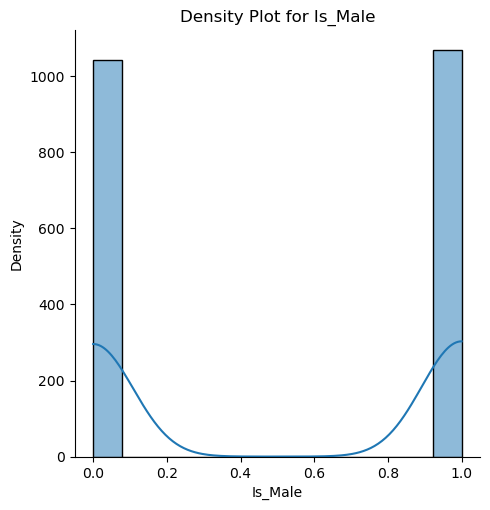

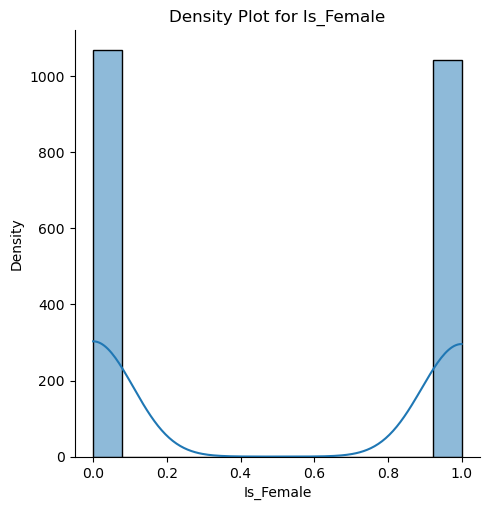

In [19]:

numerical_columns = ['Age', 'Height', 'Weight', 'family_history', 'high_caloric_food', 
                     'vegetable_intake', 'num_meals', 'snacks_btw_meals', 'SMOKE', 
                     'water_intake', 'monitor_calories?', 'physical_activity', 
                     'tech_time', 'alcohol', 'Is_Male', 'Is_Female']


for column in numerical_columns:
    sns.displot(df[column], kde=True)
    plt.title(f'Density Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()


Correlation Heatmap

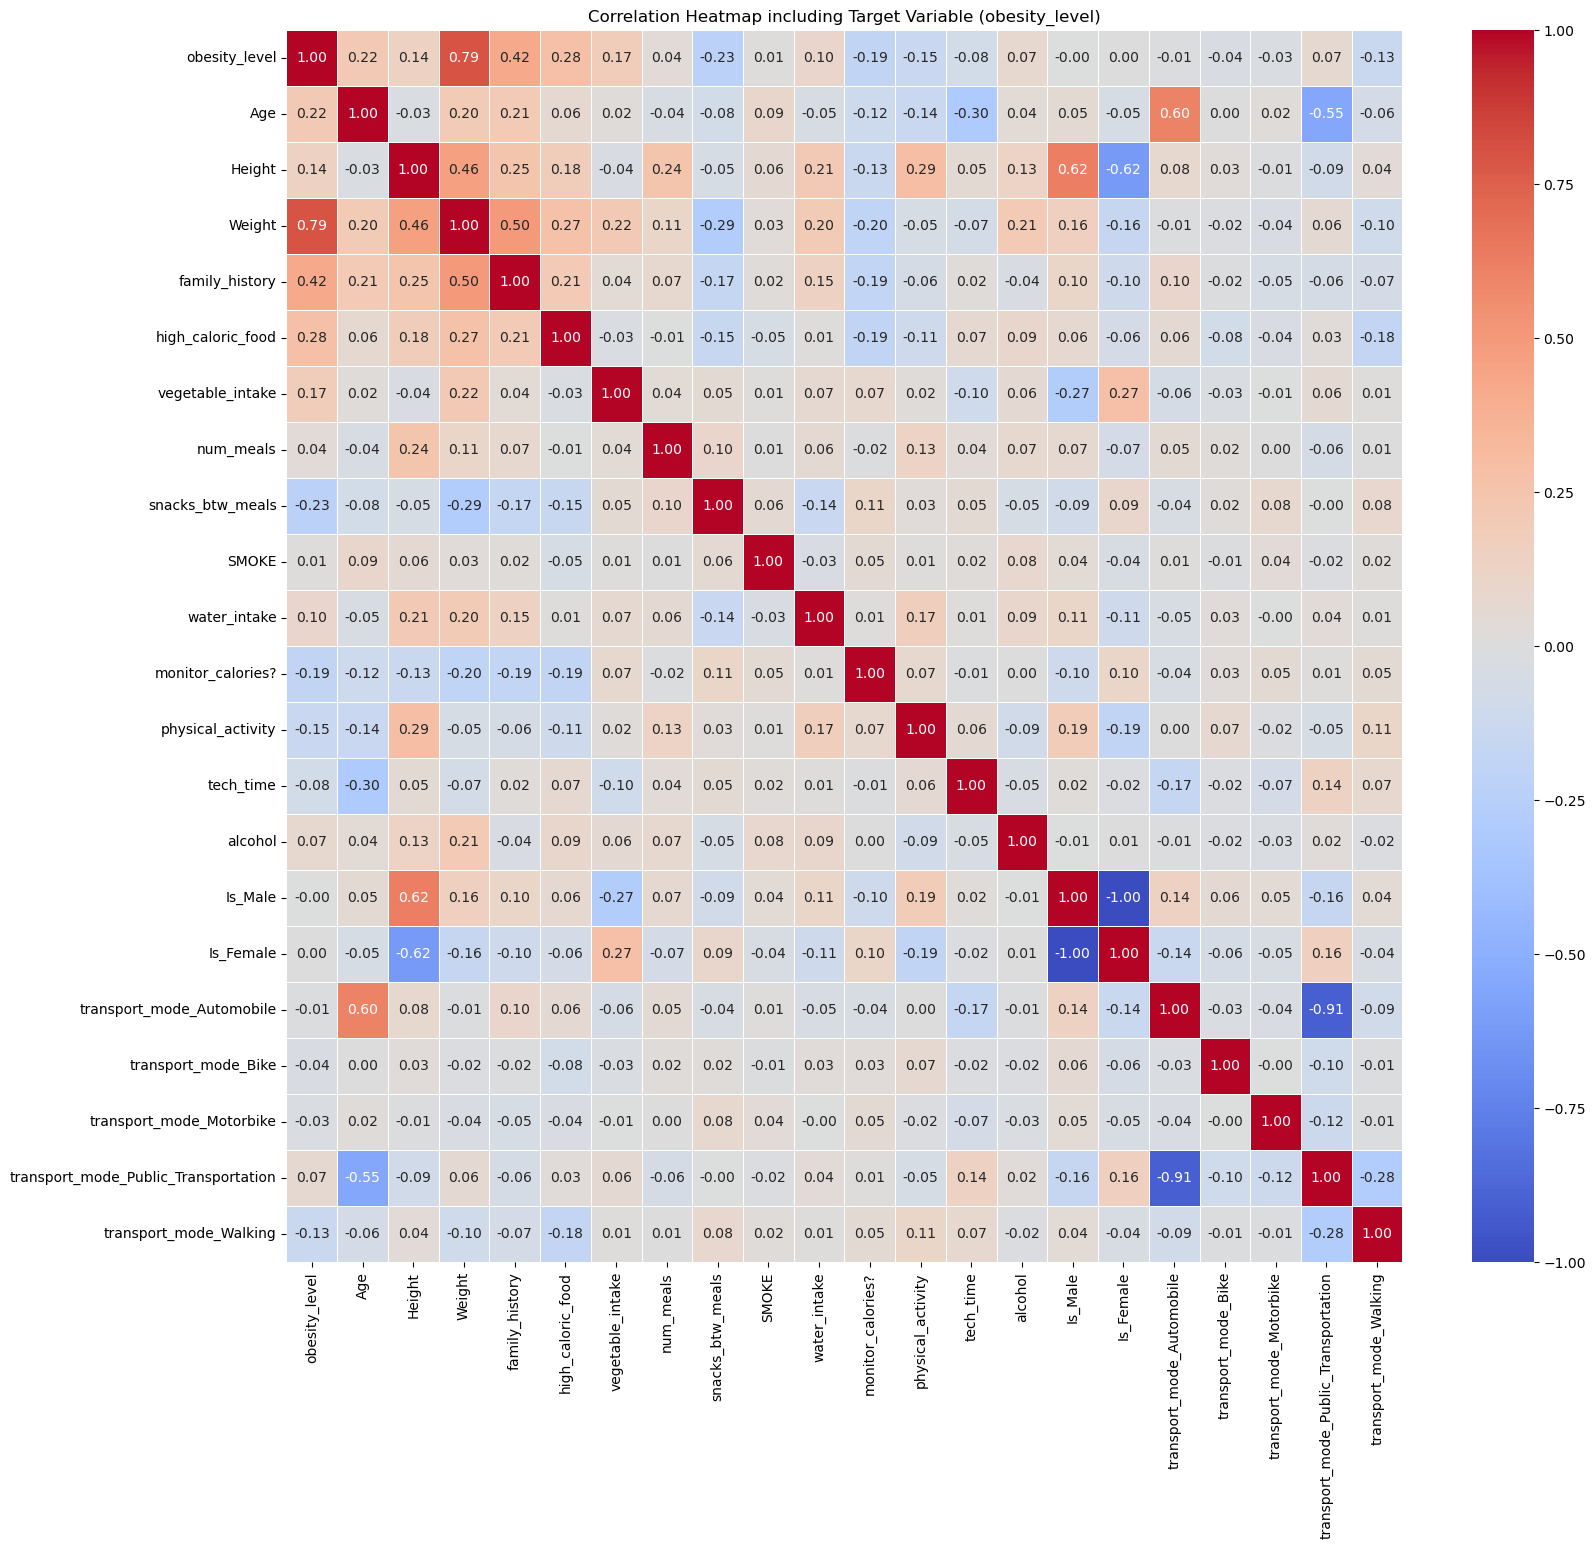

In [20]:
correlation_matrix = df.corr()

plt.figure(figsize=(18, 16))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap including Target Variable (obesity_level)')
plt.show()

Training the Model (XGBOOST)

In [21]:
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['obesity_level'])

In [22]:
train

,obesity_level,Age,Height,Weight,family_history,high_caloric_food,vegetable_intake,num_meals,snacks_btw_meals,SMOKE,...,physical_activity,tech_time,alcohol,Is_Male,Is_Female,transport_mode_Automobile,transport_mode_Bike,transport_mode_Motorbike,transport_mode_Public_Transportation,transport_mode_Walking
1786,1,24.982997,1.789680,118.436166,1,1,1.469384,2.996444,1,0,...,1.082236,0.150544,1,1,0,0,0,0,1,0
1821,1,20.590046,1.736276,130.927138,1,1,3.000000,3.000000,1,0,...,1.463610,0.962336,1,0,1,0,0,0,1,0
139,0,25.000000,1.700000,68.000000,0,1,2.000000,3.000000,2,0,...,0.000000,1.000000,0,1,0,0,0,0,1,0
800,0,18.000000,1.644682,68.392133,1,1,2.000000,1.131695,1,0,...,0.000000,1.592570,0,0,1,0,0,0,1,0
1188,0,19.005725,1.599999,73.513873,1,0,2.942154,2.667711,1,0,...,1.524405,0.805008,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,0,19.858973,1.620000,69.575315,0,1,2.185938,1.000000,0,0,...,1.000000,1.110222,1,1,0,0,0,0,1,0
957,0,39.214514,1.580765,62.631382,1,1,2.487167,3.000000,1,0,...,0.577063,0.435072,1,0,1,1,0,0,0,0
1892,1,20.951084,1.708581,131.274851,1,1,3.000000,3.000000,1,0,...,1.684582,0.887388,1,0,1,0,0,0,1,0
1373,1,26.032416,1.824432,105.131956,1,1,3.000000,3.000000,1,0,...,1.890907,1.584830,1,1,0,0,0,0,1,0


In [23]:
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['obesity_level'])

In [24]:
print(train.shape)
print(test.shape)
print(validate.shape)

(1688, 22)
(211, 22)
(212, 22)


In [25]:
print(train['obesity_level'].value_counts())
print(test['obesity_level'].value_counts())
print(validate['obesity_level'].value_counts())

obesity_level
0    911
1    777
Name: count, dtype: int64
obesity_level
0    114
1     97
Name: count, dtype: int64
obesity_level
0    114
1     98
Name: count, dtype: int64


In [26]:
model = XGBClassifier(objective='binary:logistic', eval_metric='auc', num_round=42)
print(model.fit(train.drop(['obesity_level'], axis = 1).values, train['obesity_level'].values))
print("Training Completed")

with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved successfully.")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, num_round=42, ...)
Training Completed
Model saved successfully.


In [27]:
test.head(5)

,obesity_level,Age,Height,Weight,family_history,high_caloric_food,vegetable_intake,num_meals,snacks_btw_meals,SMOKE,...,physical_activity,tech_time,alcohol,Is_Male,Is_Female,transport_mode_Automobile,transport_mode_Bike,transport_mode_Motorbike,transport_mode_Public_Transportation,transport_mode_Walking
138,0,31.000000,1.760000,75.000000,1,0,3.000000,3.000000,3,0,...,3.000000,0.000000,0,1,0,0,1,0,0,0
711,0,18.094079,1.723328,50.000000,0,1,1.052699,3.998618,2,0,...,2.000000,1.000000,1,0,1,0,0,0,1,0
1742,1,27.931432,1.805445,119.484614,1,1,2.911312,3.000000,1,0,...,0.946760,0.785701,1,1,0,1,0,0,0,0
1509,1,19.045357,1.612910,82.193405,1,1,1.261288,2.930044,1,0,...,0.133398,0.951740,0,0,1,0,0,0,1,0
182,0,22.000000,1.680000,52.000000,0,1,3.000000,3.000000,2,0,...,0.000000,1.000000,0,0,1,0,0,0,1,0


In [28]:
batch_X = test.iloc[:,1:];
batch_X.head()

,Age,Height,Weight,family_history,high_caloric_food,vegetable_intake,num_meals,snacks_btw_meals,SMOKE,water_intake,...,physical_activity,tech_time,alcohol,Is_Male,Is_Female,transport_mode_Automobile,transport_mode_Bike,transport_mode_Motorbike,transport_mode_Public_Transportation,transport_mode_Walking
138,31.000000,1.760000,75.000000,1,0,3.000000,3.000000,3,0,3.000000,...,3.000000,0.000000,0,1,0,0,1,0,0,0
711,18.094079,1.723328,50.000000,0,1,1.052699,3.998618,2,0,1.000000,...,2.000000,1.000000,1,0,1,0,0,0,1,0
1742,27.931432,1.805445,119.484614,1,1,2.911312,3.000000,1,0,2.501808,...,0.946760,0.785701,1,1,0,1,0,0,0,0
1509,19.045357,1.612910,82.193405,1,1,1.261288,2.930044,1,0,1.166655,...,0.133398,0.951740,0,0,1,0,0,0,1,0
182,22.000000,1.680000,52.000000,0,1,3.000000,3.000000,2,0,2.000000,...,0.000000,1.000000,0,0,1,0,0,0,1,0


In [29]:
predicted_probabilities = model.predict_proba(batch_X)

In [30]:
target_predicted = pd.DataFrame(predicted_probabilities[:, 1], columns=['obesity_level'])
target_predicted.head(5)

,obesity_level
0,0.000041
1,0.000053
2,0.998574
3,0.999524
4,0.000131


In [31]:
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['obesity_level'].apply(binary_convert)

print(target_predicted.head(10))
test.head(10)

   obesity_level
0       0.000041
1       0.000053
2       0.998574
3       0.999524
4       0.000131
5       0.990306
6       0.000050
7       0.000678
8       0.999950
9       0.001899


,obesity_level,Age,Height,Weight,family_history,high_caloric_food,vegetable_intake,num_meals,snacks_btw_meals,SMOKE,...,physical_activity,tech_time,alcohol,Is_Male,Is_Female,transport_mode_Automobile,transport_mode_Bike,transport_mode_Motorbike,transport_mode_Public_Transportation,transport_mode_Walking
138,0,31.000000,1.760000,75.000000,1,0,3.000000,3.000000,3,0,...,3.000000,0.000000,0,1,0,0,1,0,0,0
711,0,18.094079,1.723328,50.000000,0,1,1.052699,3.998618,2,0,...,2.000000,1.000000,1,0,1,0,0,0,1,0
1742,1,27.931432,1.805445,119.484614,1,1,2.911312,3.000000,1,0,...,0.946760,0.785701,1,1,0,1,0,0,0,0
1509,1,19.045357,1.612910,82.193405,1,1,1.261288,2.930044,1,0,...,0.133398,0.951740,0,0,1,0,0,0,1,0
182,0,22.000000,1.680000,52.000000,0,1,3.000000,3.000000,2,0,...,0.000000,1.000000,0,0,1,0,0,0,1,0
1424,1,36.679330,1.780725,98.790167,1,1,2.540949,1.116401,1,0,...,2.787319,0.732881,2,1,0,1,0,0,0,0
442,0,26.000000,1.720000,65.000000,1,1,2.000000,3.000000,1,0,...,0.000000,1.000000,1,1,0,0,0,0,0,1
930,0,21.009437,1.606810,67.773914,1,1,2.000000,3.156309,0,0,...,1.179592,0.086868,1,0,1,0,0,0,1,0
1799,1,25.919241,1.611462,102.093223,1,1,3.000000,3.000000,1,0,...,0.050930,1.000000,1,0,1,0,0,0,1,0
1154,0,22.882558,1.793451,89.909259,1,1,1.899116,2.375026,1,0,...,0.000000,1.365793,1,1,0,0,0,0,1,0


In [32]:
test_labels = test.iloc[:,0]
test_labels.head(5)

138     0
711     0
1742    1
1509    1
182     0
Name: obesity_level, dtype: int64

In [33]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Normal','Obese'],columns=['Normal','Obese'])

df_confusion

,Normal,Obese
Normal,113,1
Obese,0,97


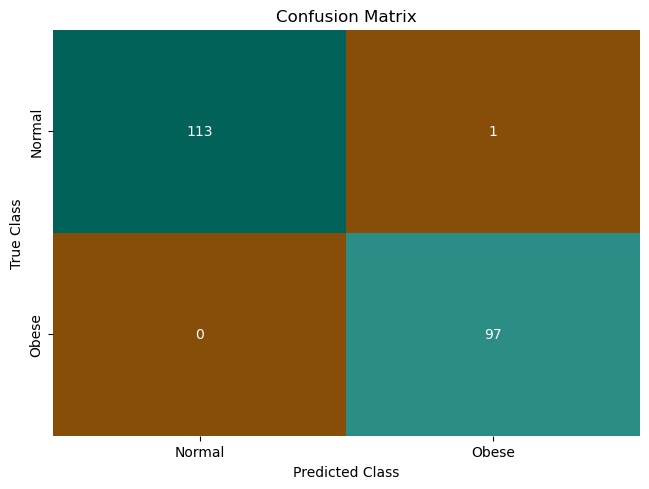

In [34]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap, fmt='g')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [35]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 113
False Positive (FP): 1
False Negative (FN): 0
True Positive (TP) : 97


In [36]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

Sensitivity or TPR: 100.0%
There is a 100.0% chance of detecting patients with an abnormality have an abnormality
Specificity or TNR: 99.12280701754386%
There is a 99.12280701754386% chance of detecting normal patients are normal.
Precision: 98.9795918367347%
You have an abnormality, and the probablity that is correct is 98.9795918367347%
Negative Predictive Value: 100.0%
You don't have an abnormality, but there is a 100.0% chance that is incorrect
False Positive Rate: 0.8771929824561403%
There is a 0.8771929824561403% chance that this positive result is incorrect.
False Negative Rate: 0.0%
There is a 0.0% chance that this negative result is incorrect.
False Discovery Rate: 1.0204081632653061%
You have an abnormality, but there is a 1.0204081632653061% chance this is incorrect.


In [37]:
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 99.52606635071089%


In [38]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 100.0%
Specificity or TNR: 99.12280701754386%
Precision: 98.9795918367347%
Negative Predictive Value: 100.0%
False Positive Rate: 0.8771929824561403%
False Negative Rate: 0.0%
False Discovery Rate: 1.0204081632653061%
Accuracy: 99.52606635071089%


Random Forest

In [39]:
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['obesity_level'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['obesity_level'])

model = RandomForestClassifier(n_estimators=100, random_state=42)


model.fit(train.drop(['obesity_level'], axis=1), train['obesity_level'])


with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Random Forest model saved successfully.")

Random Forest model saved successfully.


Predicting probabilities, threshold .5

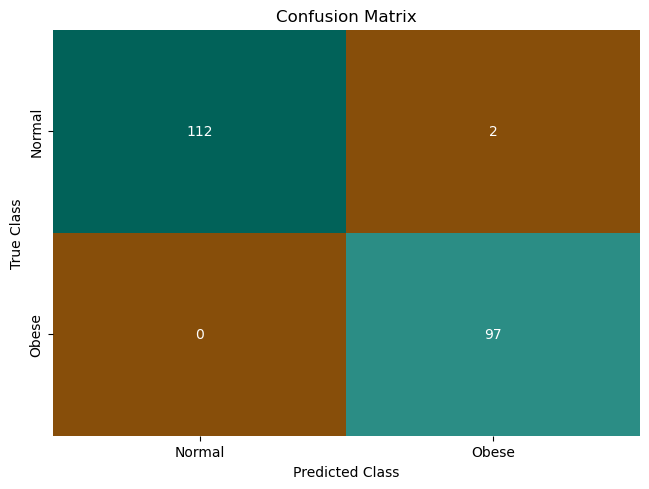

In [40]:
test_predictions_proba = model.predict_proba(test.drop(['obesity_level'], axis=1))[:, 1]  
test_predictions = (test_predictions_proba > 0.5).astype(int) 

conf_matrix = confusion_matrix(test['obesity_level'], test_predictions)

# Plot the confusion matrix with custom labels
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(conf_matrix, annot=True, cbar=None, cmap=colormap, fmt='g')


plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.xticks([0.5, 1.5], ['Normal', 'Obese']) 
plt.yticks([0.5, 1.5], ['Normal', 'Obese'])
plt.show()

In [41]:
TN, FP, FN, TP = confusion_matrix(test['obesity_level'], test_predictions).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 112
False Positive (FP): 2
False Negative (FN): 0
True Positive (TP) : 97


In [42]:
sensitivity = TP / (TP + FN)

precision = TP / (TP + FP)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Sensitivity (Recall): 1.00
F1 Score: 0.99
Accuracy: 0.99


Hyperparameter tuning

In [43]:
%%time
from sklearn.model_selection import RandomizedSearchCV
xgb_model = xgb.XGBClassifier(eval_metric='error@.40',
                              objective='binary:logistic')
hyperparameter_ranges = {'alpha': [i for i in range(0, 101)],
                         'min_child_weight': [i for i in range(1, 6)],
                         'subsample': [i / 10 for i in range(5, 11)],
                         'eta': [i / 10 for i in range(1, 4)]}

search = RandomizedSearchCV(estimator=xgb_model,
                            param_distributions=hyperparameter_ranges,
                            scoring='neg_mean_squared_error',
                            n_iter=10,  
                            cv=5,       
                            verbose=1,
                            n_jobs=1)  

search.fit(train.drop(['obesity_level'], axis = 1).values, train['obesity_level'].values)
best_params = search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 24.1 s
Wall time: 6.26 s


In [44]:
best_params

{'subsample': 0.6, 'min_child_weight': 1, 'eta': 0.1, 'alpha': 7}

In [45]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False, inplace=True)


top_models = cv_results.head(10)
print(top_models[['params', 'mean_test_score']])


best_params = search.best_params_
print("Best Hyperparameters:", best_params)

#xgboost w/ best parameters
best_xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='error', **best_params)

#training
best_xgb_model.fit(train.drop(['obesity_level'], axis = 1).values, train['obesity_level'].values)


                                              params  mean_test_score
2  {'subsample': 0.6, 'min_child_weight': 1, 'eta...        -0.011843
1  {'subsample': 0.9, 'min_child_weight': 2, 'eta...        -0.012433
3  {'subsample': 0.9, 'min_child_weight': 5, 'eta...        -0.026069
6  {'subsample': 0.9, 'min_child_weight': 1, 'eta...        -0.027256
0  {'subsample': 1.0, 'min_child_weight': 5, 'eta...        -0.034367
8  {'subsample': 0.6, 'min_child_weight': 5, 'eta...        -0.037329
9  {'subsample': 1.0, 'min_child_weight': 2, 'eta...        -0.039101
5  {'subsample': 0.6, 'min_child_weight': 5, 'eta...        -0.053321
4  {'subsample': 0.6, 'min_child_weight': 5, 'eta...        -0.062818
7  {'subsample': 0.7, 'min_child_weight': 5, 'eta...        -0.073471
Best Hyperparameters: {'subsample': 0.6, 'min_child_weight': 1, 'eta': 0.1, 'alpha': 7}


XGBClassifier(alpha=7, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='error',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [46]:
batch_X = test.iloc[:,1:];
predicted_probabilities = best_xgb_model.predict_proba(batch_X)
target_predicted = pd.DataFrame(predicted_probabilities[:, 1], columns=['obesity_level'])
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = target_predicted['obesity_level'].apply(binary_convert)
test_labels = test.iloc[:,0]

In [47]:
def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

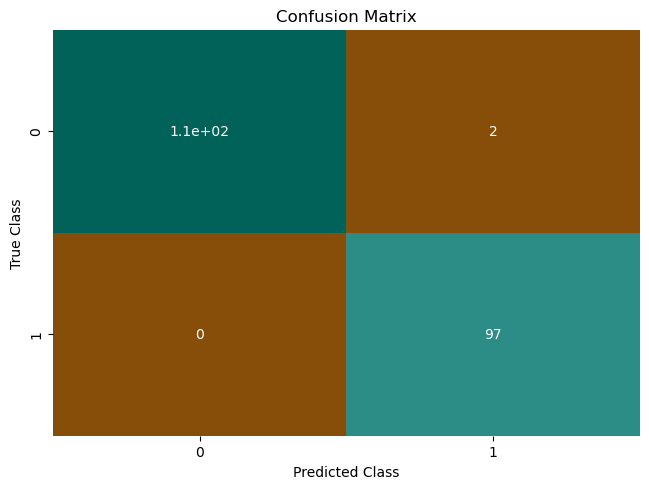

In [48]:
plot_confusion_matrix(test_labels, best_target_predicted_binary)

In [49]:
def calculate_metrics(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100
    
    metrics_df = pd.DataFrame({
        'Metric': ['Sensitivity (TPR)', 'Specificity (TNR)', 'Precision', 
                   'Negative Predictive Value', 'False Positive Rate', 
                   'False Negative Rate', 'False Discovery Rate', 'Accuracy'],
        'Value': [Sensitivity, Specificity, Precision, NPV, FPR, FNR, FDR, ACC]
    })
    
    return metrics_df
metrics_table = calculate_metrics(test_labels, target_predicted_binary)

metrics_table

,Metric,Value
0,Sensitivity (TPR),100.000000
1,Specificity (TNR),99.122807
2,Precision,98.979592
3,Negative Predictive Value,100.000000
4,False Positive Rate,0.877193
5,False Negative Rate,0.000000
6,False Discovery Rate,1.020408
7,Accuracy,99.526066


GUI

In [50]:

def validate_inputs():
    try:
  
        age = float(age_entry.get())
        if not (0 <= age <= 120):
            raise ValueError("Age must be between 0 and 120.")

    
        height = float(height_entry.get())
        if not (0 <= height <= 3):
            raise ValueError("Height must be between 0 and 3 meters.")

     
        weight = float(weight_entry.get())
        if not (0 <= weight <= 500):
            raise ValueError("Weight must be between 0 and 500 kilograms.")

 
        family_history = int(family_history_entry.get())
        if family_history not in [0, 1]:
            raise ValueError("Family History must be 0 or 1.")

     
        high_caloric_food = int(high_caloric_food_entry.get())
        if high_caloric_food not in [0, 1]:
            raise ValueError("High Caloric Food must be 0 or 1.")

      
        vegetable_intake = float(vegetable_intake_entry.get())
        if vegetable_intake not in [0, 1, 2]:
            raise ValueError("Vegetable Intake must be 0, 1, or 2.")

     
        num_meals = float(num_meals_entry.get())
        if num_meals <= 0:
            raise ValueError("Number of Meals must be greater than 0.")

    
        snacks_btw_meals = int(snacks_btw_meals_entry.get())
        if snacks_btw_meals not in [0, 1, 2, 3]:
            raise ValueError("Snacks Between Meals must be 0, 1, 2, or 3.")

    
        smoke = int(smoke_entry.get())
        if smoke not in [0, 1]:
            raise ValueError("Smoke must be 0 or 1.")

     
        water_intake = float(water_intake_entry.get())
        if water_intake not in [0, 1, 2, 3]:
            raise ValueError("Water Intake must be 0, 1, 2, or 3.")

   
        monitor_calories = int(monitor_calories_entry.get())
        if monitor_calories not in [0, 1]:
            raise ValueError("Monitor Calories must be 0 or 1.")


        physical_activity = float(physical_activity_entry.get())
        if not (0 <= physical_activity <= 24):
            raise ValueError("Physical Activity must be between 0 and 24 hours.")

   
        tech_time = float(tech_time_entry.get())
        if not (0 <= tech_time <= 24):
            raise ValueError("Tech Time must be between 0 and 24 hours.")

  
        alcohol = float(alcohol_entry.get())
        if alcohol not in [0, 1, 2, 3]:
            raise ValueError("Alcohol must be 0, 1, 2, or 3.")

   
        is_male = int(is_male_entry.get())
        if is_male not in [0, 1]:
            raise ValueError("Is Male must be 0 or 1.")

   
        is_female = int(is_female_entry.get())
        if is_female not in [0, 1]:
            raise ValueError("Is Female must be 0 or 1.")

     
        for mode_entry in transport_mode_entries.values():
            mode = int(mode_entry.get())
            if mode not in [0, 1]:
                raise ValueError("Transport Mode must be 0 or 1.")
        
       #if everythings good, then it will predict normal or obese
        predict_obesity()

    except ValueError as ve:
        messagebox.showerror("Input Error", str(ve))

def predict_obesity():
   
    with open("random_forest_model.pkl", "rb") as f:
        model = pickle.load(f)

 
    new_data = pd.DataFrame({
        'Age': [float(age_entry.get())],
        'Height': [float(height_entry.get())],
        'Weight': [float(weight_entry.get())],
        'family_history': [int(family_history_entry.get())],
        'high_caloric_food': [int(high_caloric_food_entry.get())],
        'vegetable_intake': [float(vegetable_intake_entry.get())],
        'num_meals': [float(num_meals_entry.get())],
        'snacks_btw_meals': [int(snacks_btw_meals_entry.get())],
        'SMOKE': [int(smoke_entry.get())],
        'water_intake': [float(water_intake_entry.get())],
        'monitor_calories?': [int(monitor_calories_entry.get())],
        'physical_activity': [float(physical_activity_entry.get())],
        'tech_time': [float(tech_time_entry.get())],
        'alcohol': [float(alcohol_entry.get())],
        'Is_Male': [int(is_male_entry.get())],
        'Is_Female': [int(is_female_entry.get())],
        'transport_mode_Automobile': [int(transport_mode_entries['Automobile'].get())],
        'transport_mode_Bike': [int(transport_mode_entries['Bike'].get())],
        'transport_mode_Motorbike': [int(transport_mode_entries['Motorbike'].get())],
        'transport_mode_Public_Transportation': [int(transport_mode_entries['Public_Transportation'].get())],
        'transport_mode_Walking': [int(transport_mode_entries['Walking'].get())]
    })

 
    prediction = model.predict(new_data)

  #what the output should be after clicking predict
    result = "Normal" if prediction[0] == 0 else "Obese"
    messagebox.showinfo("Prediction", f"Predicted obesity level: {result}")

# Creating the window
root = tk.Tk()
root.title("Normal or Obese Prediction")


age_label = tk.Label(root, text="Age:")
age_label.grid(row=0, column=0)
age_entry = tk.Entry(root)
age_entry.grid(row=0, column=1)


height_label = tk.Label(root, text="Height (In Meters):")
height_label.grid(row=1, column=0)
height_entry = tk.Entry(root)
height_entry.grid(row=1, column=1)


weight_label = tk.Label(root, text="Weight (In Kg):")
weight_label.grid(row=2, column=0)
weight_entry = tk.Entry(root)
weight_entry.grid(row=2, column=1)


family_history_label = tk.Label(root, text="Family History (1 = Yes, 0 = No):")
family_history_label.grid(row=3, column=0)
family_history_entry = tk.Entry(root)
family_history_entry.grid(row=3, column=1)


high_caloric_food_label = tk.Label(root, text="High Caloric Food (1 for Yes, 0 for No):")
high_caloric_food_label.grid(row=4, column=0)
high_caloric_food_entry = tk.Entry(root)
high_caloric_food_entry.grid(row=4, column=1)


vegetable_intake_label = tk.Label(root, text="Vegetable Intake (0 = Never, 1 = Sometimes, 2 = Always):")
vegetable_intake_label.grid(row=5, column=0)
vegetable_intake_entry = tk.Entry(root)
vegetable_intake_entry.grid(row=5, column=1)


num_meals_label = tk.Label(root, text="Number of Meals:")
num_meals_label.grid(row=6, column=0)
num_meals_entry = tk.Entry(root)
num_meals_entry.grid(row=6, column=1)


snacks_btw_meals_label = tk.Label(root, text="Snacks Between Meals (0 for no, 1 for sometimes, 2 for frequently, 3 for always):")
snacks_btw_meals_label.grid(row=7, column=0)
snacks_btw_meals_entry = tk.Entry(root)
snacks_btw_meals_entry.grid(row=7, column=1)


smoke_label = tk.Label(root, text="Smoke (1 for Yes, 0 for No):")
smoke_label.grid(row=8, column=0)
smoke_entry = tk.Entry(root)
smoke_entry.grid(row=8, column=1)


water_intake_label = tk.Label(root, text="Water Intake(0 =<liter, 1 = 1-2liter, 3 = >3liter):")
water_intake_label.grid(row=9, column=0)
water_intake_entry = tk.Entry(root)
water_intake_entry.grid(row=9, column=1)


monitor_calories_label = tk.Label(root, text="Monitor Calories? (1 for Yes, 0 for No):")
monitor_calories_label.grid(row=10, column=0)
monitor_calories_entry = tk.Entry(root)
monitor_calories_entry.grid(row=10, column=1)

physical_activity_label = tk.Label(root, text="Physical Activity (0 for don't, 1 for 1-2 days, 2 for 2-4 days, 3 for 4-5 days/week):")
physical_activity_label.grid(row=11, column=0)
physical_activity_entry = tk.Entry(root)
physical_activity_entry.grid(row=11, column=1)


tech_time_label = tk.Label(root, text="Tech Time (hours/day):")
tech_time_label.grid(row=12, column=0)
tech_time_entry = tk.Entry(root)
tech_time_entry.grid(row=12, column=1)


alcohol_label = tk.Label(root, text="Alcohol (0 for no, 1 for sometimes, 2 for frequently, 3 for always):")
alcohol_label.grid(row=13, column=0)
alcohol_entry = tk.Entry(root)
alcohol_entry.grid(row=13, column=1)


is_male_label = tk.Label(root, text="Is Male (1 for Yes, 0 for No):")
is_male_label.grid(row=14, column=0)
is_male_entry = tk.Entry(root)
is_male_entry.grid(row=14, column=1)


is_female_label = tk.Label(root, text="Is Female (1 for Yes, 0 for No):")
is_female_label.grid(row=15, column=0)
is_female_entry = tk.Entry(root)
is_female_entry.grid(row=15, column=1)


transport_mode_label = tk.Label(root, text="Transport Mode:")
transport_mode_label.grid(row=16, column=0)

transport_mode_entries = {}
transport_modes = ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']
for i, mode in enumerate(transport_modes):
    label = tk.Label(root, text=mode)
    label.grid(row=16, column=i+1)
    entry = tk.Entry(root)
    entry.grid(row=17, column=i+1)
    transport_mode_entries[mode] = entry

# adding the predict button
predict_button = tk.Button(root, text="Predict", command=validate_inputs)
predict_button.grid(row=18, columnspan=6)


root.mainloop()
